### Import the necessary libraries


In [24]:
import re
import nltk
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('all')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipp

True

### Load the Dataset


In [2]:
df = pd.read_csv('Dataset/Training_Essay_Data.csv')
df.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


### Analyzing the missing values


<Axes: >

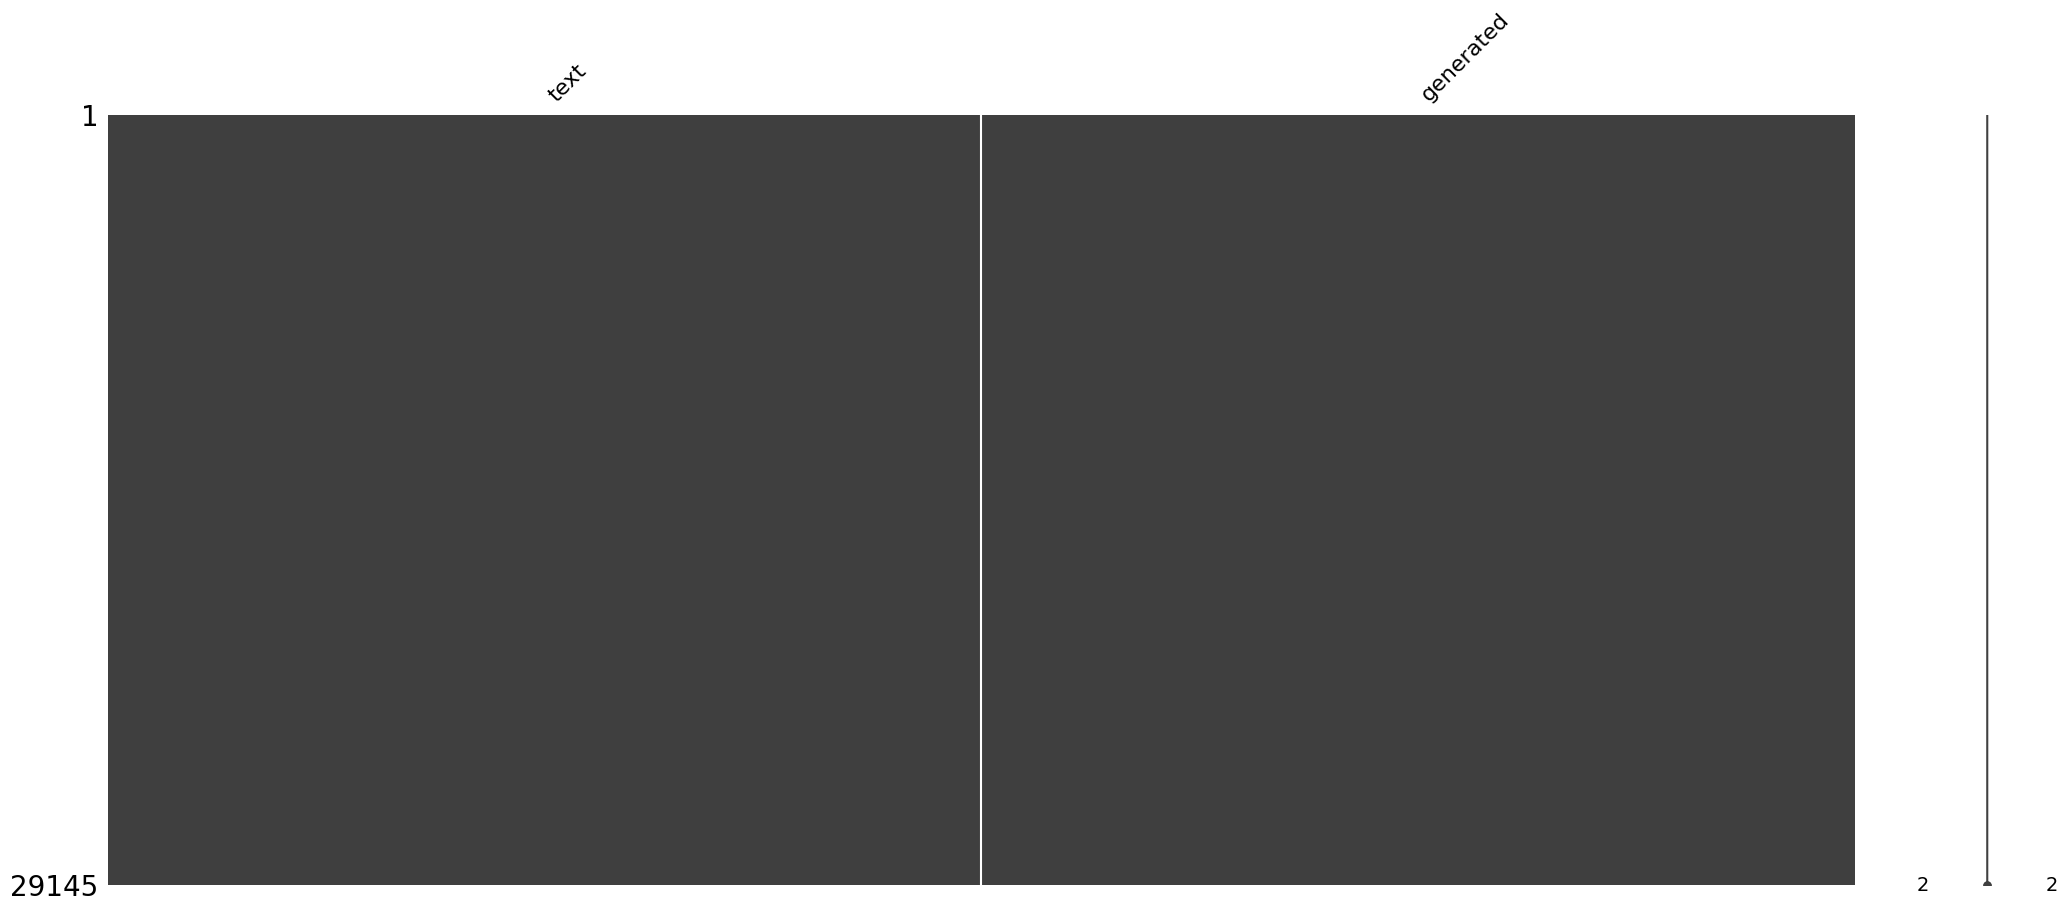

In [3]:
msno.matrix(df)

### Dataset Characterstics


Dataset size


In [4]:
df.shape

(29145, 2)

Checking for Duplicates


In [5]:
print('Duplicate Rows: ', len(df[df.duplicated()]))

Duplicate Rows:  1805


In [6]:
df.drop_duplicates(inplace=True)
df.shape

(27340, 2)

Check for data types


In [7]:
df.dtypes

text         object
generated     int64
dtype: object

Summary of Dataframe


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27340 entries, 0 to 27766
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27340 non-null  object
 1   generated  27340 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 640.8+ KB


Class Distribution


In [9]:
class_counts = df['generated'].value_counts()
class_counts

generated
0    16122
1    11218
Name: count, dtype: int64

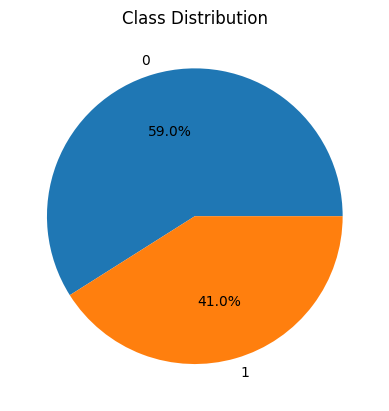

In [10]:
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

#### Initial Analysis of dataset

<ul>
    <li>Dataset initially had 29145 rows.</li>
    <li>There are only two columns in the dataset: text column has the essay text and generated column has the label (0 - Human Written Essay , 1 - AI Generated Essay).</li>
    <li>The dataset had no missing values.</li>
    <li>1805 rows with duplicate values were dropped.</li>
    <li>Almost 60% of the rows are human generated and 40% rows are AI generated.</li>
</ul>


### EDA

In [25]:
df['word_length'] = df['text'].apply(lambda text: len(text.split()))
df['sentence_count'] = df['text'].apply(lambda text: len(nltk.sent_tokenize(text)))
df.head()

,text,generated,word_length,sentence_count
0,Car-free cities have become a subject of incre...,1,575,28
1,"Car Free Cities Car-free cities, a concept ga...",1,513,26
2,A Sustainable Urban Future Car-free cities ...,1,512,27
3,Pioneering Sustainable Urban Living In an e...,1,519,23
4,The Path to Sustainable Urban Living In an ...,1,511,22


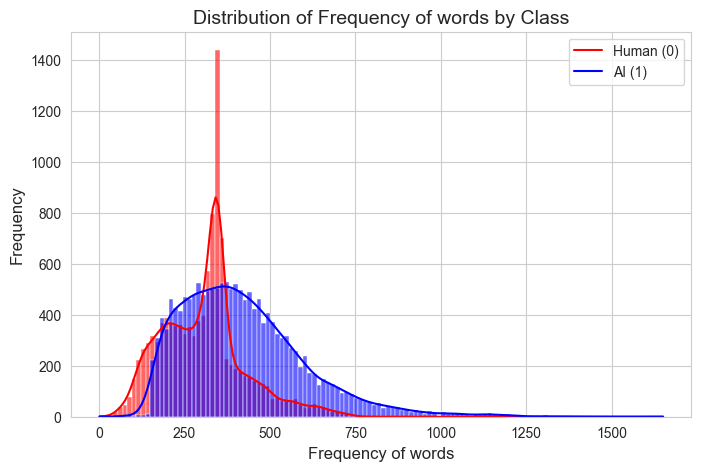

In [29]:
def plot_histogram(df, column, label_name):
    """
    Plots a histogram of sentence count color-coded by the 'generated' class.

    Parameters:
        df (pd.DataFrame): DataFrame with 'sentence_count' and 'generated' columns.
    """
    # Set style
    sns.set_style("whitegrid")

    # Create histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column, hue='generated', bins='auto', kde=True, 
                 palette={0: 'blue', 1: 'red'}, alpha=0.6)

    # Labels & Title
    plt.xlabel(f"{label_name}", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title(f"Distribution of {label_name} by Class", fontsize=14)
    plt.legend(labels=["Human (0)", "AI (1)"])

    # Show plot
    plt.show()

plot_histogram(df, 'word_length', 'Frequency of words')

### Data preprocessing

In [ ]:
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters & numbers
    tokens = nltk.word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Stopword removal
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return " ".join(tokens)